<a href="https://colab.research.google.com/github/DionesGouvea/Identificacao-de-fraudes/blob/main/Identificacao_de_fraudes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Contexto analíico
O banco xxxxxxx quer diminuir os casos de fraudes em suas transações bancárias atualmente o banco conta com um algoritimo que não identifica a maioria das operações fraudulentas, gerando grandes percas.

**Objetivo 1:** entregar um modelo que identifique o maior número de casos de fraude e que tenha o melhor trade off possível entre transações reais x fraudes. 

Além de ter um modelo que identifique as fraudes é preciso que ele realize inferencias no menor tempo possível.

**Objetivo 2** Aplicar o uso de GPU para o modelo em busca de um tempo de inferência menor.  

##Dados

O conjunto de dados é uma simulação feita com base em uma amostra de transações reais, extraidas de um mês de registros financeiros de um serviço de dinheiro movel implementado em um pais africano. Os registros originais foram fornecidos por uma empresa multinacional, que é a provedora do serviço financeiro móvel que atualmente está sendo executado em mais de 14 países em todo o mundo.

Para saber mais como esses dados foram gerados e também um entendimento melhor sobre suas variaveis pode se ler este artigo [PAYSIM: UM SIMULADOR DE DINHEIRO MÓVEL FINANCEIRO PARA DETECÇÃO DE FRAUDES](https://www.researchgate.net/publication/313138956_PAYSIM_A_FINANCIAL_MOBILE_MONEY_SIMULATOR_FOR_FRAUD_DETECTION)

Features:
- **step** - representa o total de horas transcorrido desde o início da simulação. Esta feature vai variar entre 1 e 744 (30 dias);

- **type** - Tipo: tipo de transação (depósito, saque, débito, pagamento e transferência);

- **amount** - total que foi transacionado;

- **nameOrig** - cliente que iniciou a transação

- **oldbalanceOrg** - saldo da conta de origem antes da transação;

- **newbalanceOrig** - saldo da conta de origem após a transação;

- **nameDest** - cliente de destino da transação;

- **oldbalanceDest** - saldo da conta de destino antes da transação;

- **newbalanceDest** - saldo da conta de destino após a transação;

- **isFraud** - flag que define se a transação é fraudulenta ou não. Nesta simulação o objetivo da fraude é assumir a conta do usuário, esvaziá-la transferindo para outra conta e então sacando o dinheiro.

- **isFlaggedFraud** - automaticamente marcadas pelo banco como fraude por tentarem transferir mais de 200.000 em uma única transação.

## 1. Importando os Dados


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

In [40]:
from google.colab import drive 
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
df = pd.read_csv('/content/gdrive/MyDrive/Tera/Data/fraud_detection_dataset.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,840",C1231006815,"170,136","160,296",M1979787155,0,0,0,0
1,1,PAYMENT,"1,864",C1666544295,"21,249","19,385",M2044282225,0,0,0,0
2,1,TRANSFER,181,C1305486145,181,0,C553264065,0,0,1,0
3,1,CASH_OUT,181,C840083671,181,0,C38997010,"21,182",0,1,0
4,1,PAYMENT,"11,668",C2048537720,"41,554","29,886",M1230701703,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,"339,682",C786484425,"339,682",0,C776919290,0,"339,682",1,0
6362616,743,TRANSFER,"6,311,409",C1529008245,"6,311,409",0,C1881841831,0,0,1,0
6362617,743,CASH_OUT,"6,311,409",C1162922333,"6,311,409",0,C1365125890,"68,489","6,379,898",1,0
6362618,743,TRANSFER,"850,003",C1685995037,"850,003",0,C2080388513,0,0,1,0


In [42]:
df.info(null_counts= True)

<ipython-input-42-07af6ba031d6>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(null_counts= True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## 2. Analise Exploratoria 


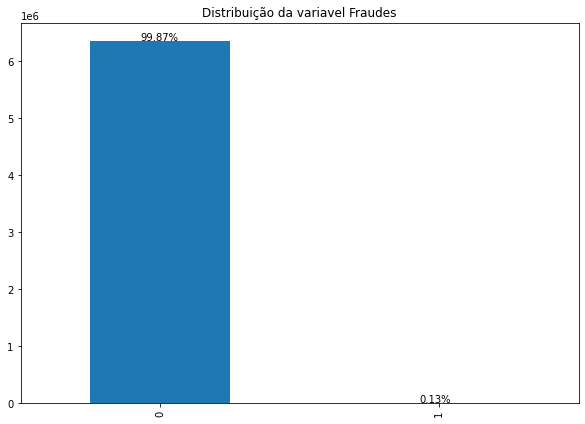

In [43]:
#verificando a ditribuição da nossa variavel target 
ax = df['isFraud'].value_counts().plot(kind = 'bar',figsize = (10,7))
ax.set_title('Distribuição da variavel Fraudes')
for p in ax.patches: # patches pega as colunas 
  #multiplicando o tamanho da coluna por 100 e dividindo pelo tamanho da variavel isfraud
  ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df.isFraud)), (p.get_x()+ 0.18, p.get_height()))

As transações fraudulentas representão apenas 0,13% do total de transações porem mesmo com um percentual baixo podem significar um prejuizo grande.

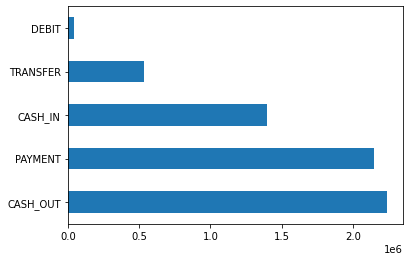

In [44]:
#visualizando a distribuição de trodas operações por tipo de operação 
df['type'].value_counts().plot(kind = 'barh')

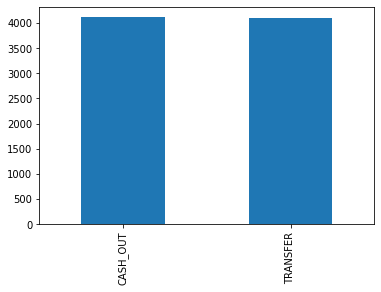

In [45]:
#visualizando a distribuição entre as operaçãões com fraudes 
df[df.isFraud == 1]['type'].value_counts().plot(kind = 'bar')

Já é possivel perceber que só houve fraude em operações do tipo transferencia e saque 

Text(0.5, 1.0, 'CASH_OUT')

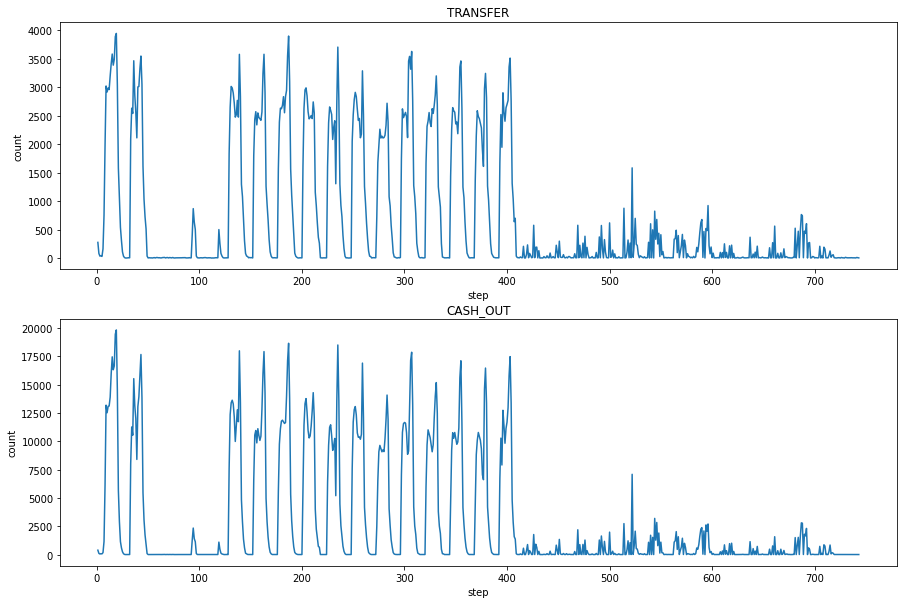

In [46]:
#visualizando as operações Cash_out e TRANSFER no decorrer do mês 
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
df[df['type'] == 'TRANSFER'].groupby('step')['step'].count().plot()
plt.ylabel('count')
plt.title('TRANSFER')

plt.subplot(2,1,2)
df[df['type'] == 'CASH_OUT'].groupby('step')['step'].count().plot()
plt.ylabel('count')
plt.title('CASH_OUT')

É possivel perceber que existe uma movimentação grande de dinheiro ate aproximadamente o 15.º dia do mês, provavelmente por recebimento de salarios.

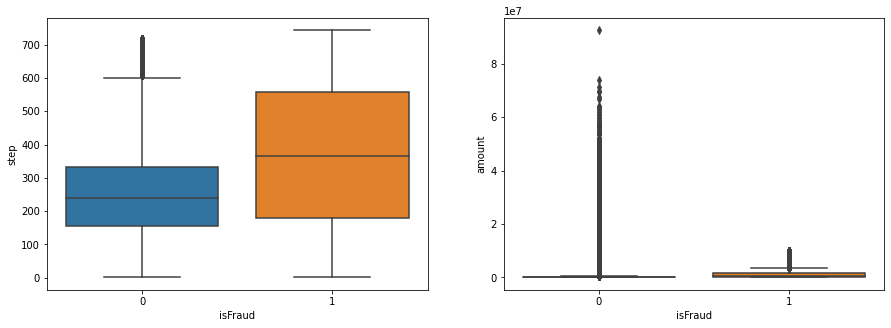

In [47]:
#quando as transações fraudulentas ocorrem e a diferença de valor medio entre transações normais
plt.figure(figsize =(15,5))
plt.subplot(1,2,1)
sns.boxplot(x = 'isFraud', y = 'step', data = df)
plt.subplot(1,2,2)
sns.boxplot(x = 'isFraud', y = 'amount', data = df)

As transações fraudulentas ocorrem em sua maioria aproximadamente entre os dias 8 e 25 do Mês, e o valor medio das transações fraudulentas é maior que o das transações sem fraude.

In [48]:
#visualizando as contas envolvidas em fraude 
df[df.isFraud == 1]['nameOrig'].value_counts()[:10],\
df[df.isFraud == 1]['nameDest'].value_counts()[:10]

(C1305486145    1
 C755286039     1
 C973279667     1
 C258213312     1
 C1640703547    1
 C1127265876    1
 C317779855     1
 C1064034527    1
 C1141104763    1
 C1966863341    1
 Name: nameOrig, dtype: int64, C1193568854    2
 C104038589     2
 C200064275     2
 C1497532505    2
 C1601170327    2
 C1655359478    2
 C2020337583    2
 C1653587362    2
 C1013511446    2
 C2129197098    2
 Name: nameDest, dtype: int64)

Em contas de origem não encontramos mais de uma transação envolvida em fraudes, porem encontramos em algumas contas de destino mais de uma transação envolvida em fraude.

Vamos olhar melhor essas contas que receberam mais de uma transação


In [49]:
from pandas.core.arrays.datetimelike import isin

#criando uma lista com os nomes das contas de destino que possuem fraude
destTransF = df[df.isFraud == 1]['nameDest'].value_counts().index.tolist()

#criando um dataframe contendo 2 colunas uma com o nome das contas e outra com o numero de transações
destTrans = pd.DataFrame({'conta': df.nameDest.value_counts().index.tolist(),
                          'Transacoes': df.nameDest.value_counts()})

#usando isin para fazer um dataframe que possui somente as contas com fraude 
destFraude = destTrans[destTrans['conta'].isin(destTransF)]


#usando negaçao para reservar as contas que nao participaram de fraudes para comparação futura 
destnorm = destTrans[~destTrans['conta'].isin(destTransF)]


destFraude

,conta,Transacoes
C716083600,C716083600,89
C667346055,C667346055,86
C932583850,C932583850,82
C766681183,C766681183,80
C803116137,C803116137,77
...,...,...
C2100877994,C2100877994,1
C825722694,C825722694,1
C195893407,C195893407,1
C2033959349,C2033959349,1


podemos ver que muitas das contas que possuem transações fraudulentas tiveram também muitas transações normais. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Transações fraudulentas')

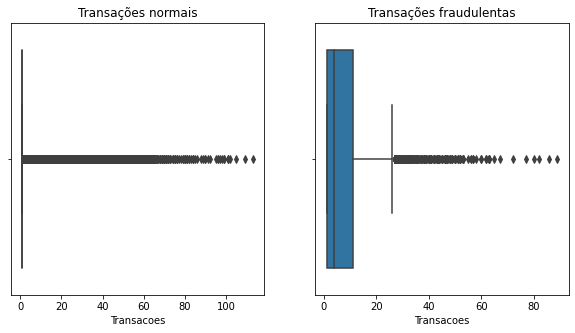

In [50]:
#verificando se existe diferença entre as contas normais e contas que tiveram fraude

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.boxplot(destnorm['Transacoes'])
plt.title('Transações normais')

plt.subplot(1,2,2)
sns.boxplot(destFraude['Transacoes'])
plt.title('Transações fraudulentas')



é possivel perceber que as contas que praticam fraudes possuem um numero maior de transações. 

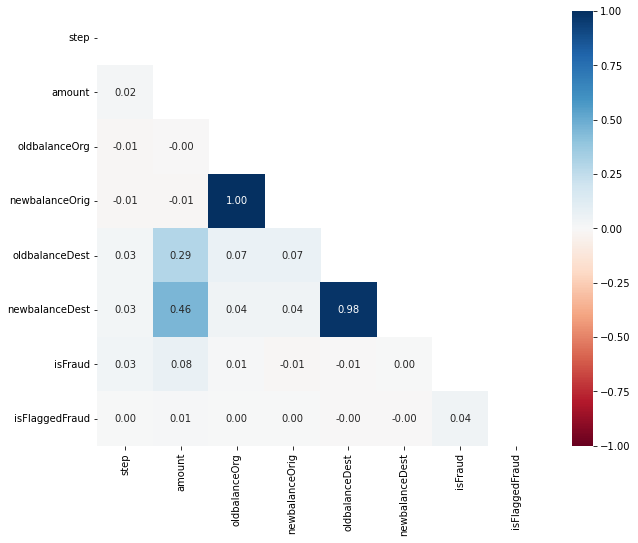

In [51]:
# plotando o heatmap de correlação no dataset
plt.figure(figsize=(10,8))
sns.heatmap(
            df.corr(),
            vmin=-1, 
            vmax=1,
            annot=True,
            fmt='.2f',
            cmap='RdBu',
            mask=np.triu( # Faz uma matriz triangular
            np.ones_like(df.corr()) # usando como base uma matriz de '1's, do mesmo tamanho que a matriz de correlação
    ) # A máscara vai então 'apagar' a diagonal superior da matriz
           )

As features não possuem correlação relevantes com nossa variavel target, vamos criar algumas features e ver se conseguimos melhorar isto. 

## 3. Feature Engineering

In [52]:
#visualizando os percentils das minhas features. 
pd.options.display.float_format = '{:,.0f}'.format
df.describe(percentiles = [0.10, 0.25,0.5,0.75,0.99])

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,"6,362,620","6,362,620","6,362,620","6,362,620","6,362,620","6,362,620","6,362,620","6,362,620"
mean,243,"179,862","833,883","855,114","1,100,702","1,224,996",0,0
std,142,"603,858","2,888,243","2,924,049","3,399,180","3,674,129",0,0
min,1,0,0,0,0,0,0,0
10%,35,"4,501",0,0,0,0,0,0
25%,156,"13,390",0,0,0,0,0,0
50%,239,"74,872","14,208",0,"132,706","214,661",0,0
75%,335,"208,721","107,315","144,258","943,037","1,111,909",0,0
99%,681,"1,615,979","16,027,256","16,176,161","12,371,819","13,137,867",0,0
max,743,"92,445,517","59,585,040","49,585,040","356,015,889","356,179,279",1,1


In [53]:
def amount_category(x):
    if x >= 210000:
      return('EXTREMLY HIGH')
    elif x < 210000 and x >= 75000:
        return('HIGH')
    elif x < 75000 and x >= 14000:
        return('MODERATE')
    elif x < 14000:
        return('LOW')
    else:
        return("EXTREMLY LOW")
df['amount_category'] = df.amount.apply(amount_category)

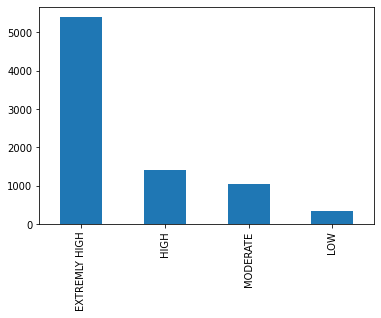

In [54]:
df[df.isFraud == 1]['amount_category'].value_counts().plot(kind = 'bar')

Podemos ver que as operações de fraude em sua grande maioria são para valores mais altos acima de 210 mil reais. 

In [55]:
#Olhando para a variavel step e definindo features de dias e horas 

df['days'] = df.step // 24 # pegando o valor absoluto da divisão para calcular o dia 
df['hours'] = df.step % 24 #pegando o resto da divisão para calcular a hora do dia sempre que o resto for 0 é meia noite

Text(0, 0.5, 'Numero de Transações')

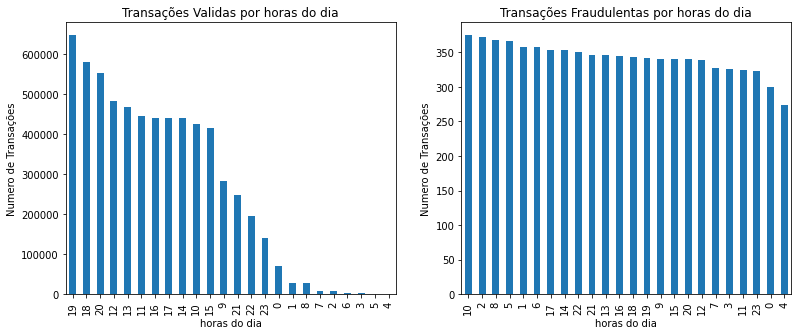

In [56]:
plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
df[df.isFraud == 0]['hours'].value_counts().plot(kind = 'bar')
plt.title('Transações Validas por horas do dia')
plt.xlabel('horas do dia')
plt.ylabel('Numero de Transações')
plt.subplot(1,2,2)
df[df.isFraud == 1]['hours'].value_counts().plot(kind = 'bar')
plt.title('Transações Fraudulentas por horas do dia')
plt.xlabel('horas do dia')
plt.ylabel('Numero de Transações')

Olhando para as horas das transações validas e transações fraudulentas podemos notar uma diferença, onde as transações validas não costumam ocorrer no periodo da madrugada até as 8 da manha.  já as transações fraudulentas ocorrem em qualquer horario. 

Text(0, 0.5, 'Numero de Transações')

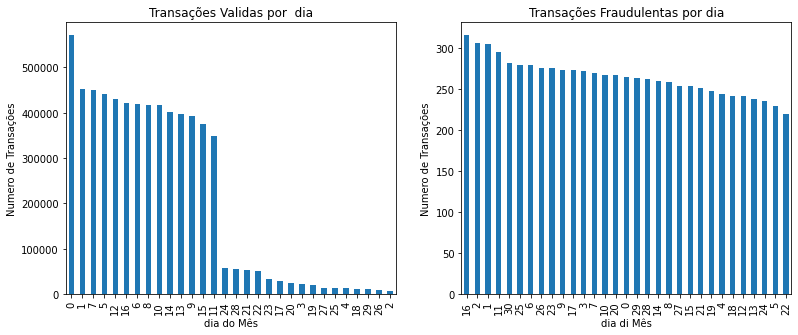

In [57]:
plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
df[df.isFraud == 0]['days'].value_counts().plot(kind = 'bar')
plt.title('Transações Validas por  dia')
plt.xlabel('dia do Mês')
plt.ylabel('Numero de Transações')
plt.subplot(1,2,2)
df[df.isFraud == 1]['days'].value_counts().plot(kind = 'bar')
plt.title('Transações Fraudulentas por dia')
plt.xlabel('dia di Mês')
plt.ylabel('Numero de Transações')

Como ja tinhamos visto antes o maior numero de transações validas ocorre entre a primeira quinzena do mês, ja quando olhamos para transações fraudulentas podemos ver que elas ocorrem durante o mes todo. 

In [58]:
#trabalhar as features conta de origem e destino

## Pre Processamento

In [59]:
#Fazendo o encoding 
df = pd.get_dummies(df, columns=['type','amount_category'])

In [60]:
X = df.drop(['isFraud','nameOrig','nameDest'], axis=1)
y = df.isFraud

In [31]:
#dividindo entre treino, teste e validação. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1603)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1603)

In [32]:
X_train.shape, X_test.shape, X_val.shape 

((4072076, 18), (1272524, 18), (1018020, 18))

In [61]:
#gerenciamento de memoria.
import gc
del df, X, y
gc.collect()

## Modelo Baseline
Irei fazer um Random Forest sem parametros somente como base de comparação para outros modelos. 

In [ ]:
# Modelos de ML
rfc = RandomForestClassifier(random_state=1603)

In [ ]:
rfc.fit(X_train, y_train)
y_pred_train_rfc_baseline = rfc.predict(X_val)
print(classification_report(y_val, y_pred_train_rfc_baseline))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016743
           1       0.99      0.82      0.90      1277

    accuracy                           1.00   1018020
   macro avg       0.99      0.91      0.95   1018020
weighted avg       1.00      1.00      1.00   1018020



É possivel ver que a precisão do modelo em acertar quando diz que uma operação é fraudulenta esta em 99% porem esta acertando apenas 82% do numero total de operações fraudulenta, ou seja de 1277 casos de operações fraudulentas 230 não estão sendo detectadas pelo modelo. 

## Under-sampling x Over-sampling 

O conjunto de dados é desbalanceado irei tentar melhorar o equilibrio e ver se o modelo desempenha melhor. 

### Under

In [ ]:
#construindo um dataframe somente com o conjunto de treinamento para aplicar o under.
df2 = pd.concat([X_train,y_train], axis = 1)
df2 = df2.rename(columns={0: 'isFraud'})

In [ ]:
# Separando o conjunto de treinamento em classe minoritária e majoritária
df_minor = df2[df2['isFraud'] == 1]
df_major = df2[df2['isFraud'] == 0]

# Reduzindo a classe majoritária para o tamanho da classe minoritária
df_major_downsampled = resample(df_major, 
                                 replace=False,    # Não sampleia com reposição
                                 n_samples=len(df_minor),     # Tamanho da nova classe majoritária
                                 random_state=1603)  

# Juntando as duas classes novamente
df_downsampled = pd.concat([df_major_downsampled, df_minor])

# Atualizando as variáveis de treinamento e alvo
X_train_Under = df_downsampled.drop(['isFraud'], axis=1)
y_train_Under = df_downsampled['isFraud']

In [ ]:
%%time
rfc.fit(X_train_Under, y_train_Under)
y_pred_train_rfc_Under = rfc.predict(X_val)
print(classification_report(y_val, y_pred_train_rfc_Under))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1016743
           1       0.10      1.00      0.18      1277

    accuracy                           0.99   1018020
   macro avg       0.55      0.99      0.58   1018020
weighted avg       1.00      0.99      0.99   1018020

CPU times: user 9.12 s, sys: 30.5 ms, total: 9.15 s
Wall time: 9.17 s


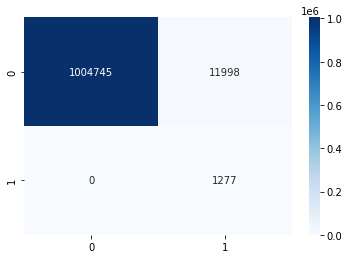

In [ ]:
# criando a matriz de confusão para o modelo Random Forest com undersampled
ax = sns.heatmap(confusion_matrix(y_val, y_pred_train_rfc_Under),
                 annot=True,
                 fmt = 'd',
                 cmap = 'Blues')

Fica claro que o Under não funcionou bem para o nosso problema, por mais que o modelo tenha conseguido detectar todos os casos de fraude ele acusou **11998** operações que não eram fraude como fraude, derrubando nossa precisão e não sendo utilizavel para este problema. 

### Over

In [ ]:
from imblearn.over_sampling import SMOTE

# Instanciando o SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=1603)

# Aplicando o SMOTE aos dados de treinamento
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

In [ ]:
X_train.shape, X_train_SMOTE.shape

((4072076, 18), (8133646, 18))

In [ ]:
%%time
rfc.fit(X_train_SMOTE, y_train_SMOTE)
y_pred_train_rfc_Over = rfc.predict(X_val)
print(classification_report(y_val, y_pred_train_rfc_Over))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016743
           1       0.74      0.92      0.82      1277

    accuracy                           1.00   1018020
   macro avg       0.87      0.96      0.91   1018020
weighted avg       1.00      1.00      1.00   1018020

CPU times: user 55min 55s, sys: 33.1 s, total: 56min 28s
Wall time: 56min 33s


Note que para rodar esse modelo levou quase 1 hora, e que começa a ficar custoso fazer analises mais extensivas 

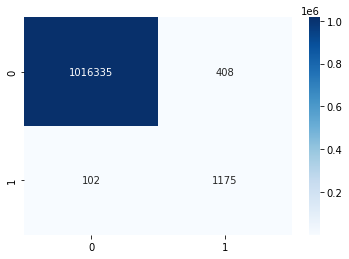

In [ ]:
# criando a matriz de confusão para o modelo Random Forest com Oversampled
ax = sns.heatmap(confusion_matrix(y_val, y_pred_train_rfc_Over),
                 annot=True,
                 fmt = 'd',
                 cmap = 'Blues')

O metodo de OverSampling comparado com nosso modelo baseline conseguiu melhorar o nosso recall e detectar mais fraudes ao custo de acusar quase 400 transações a mais que não são fraudes como fraudes. acredito que ainda de para melhorar este trade-off 

### Undersampling com ClusterCentroids 

In [ ]:
from imblearn.under_sampling import ClusterCentroids

# Criando um objeto ClusterCentroids
cc = ClusterCentroids(random_state=1603)

# Ajustando e transformando os dados de treinamento
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)